<a href="https://colab.research.google.com/github/ssegovba/identifying-deforestation/blob/main/notebooks/cnn_custom_model_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model on Amazon Rainforest Data for Deforestation Tracking
*Santiago Segovia*

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing import image
import os

from google.colab import drive

In [2]:
# Mount GDrive
drive.mount("/content/drive")

Mounted at /content/drive


## I. Data Pre-processing

### I.a Handling the Labels

We begin by loading the metadata that has the names of the labels:



In [3]:
data_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/"
train_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/train-jpg"
test_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/test-jpg"

In [4]:
# Load the CSV file with the metadata
labels_df = pd.read_csv(data_path + 'train_classes.csv')

# Add extension so image names match file names
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: x + '.jpg')

# Convert the space-separated tags into a list of tags
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split())

# Use a MultiLabelBinarizer for the tags for model training
mlb = MultiLabelBinarizer()
labels_df['encoded_tags'] = list(mlb.fit_transform(labels_df['tags']))
labels_df = labels_df[:8000]

In [ ]:
labels_df.head()

,image_name,tags,encoded_tags
0,train_0.jpg,"[haze, primary]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
1,train_1.jpg,"[agriculture, clear, primary, water]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,train_2.jpg,"[clear, primary]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,train_3.jpg,"[clear, primary]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, ..."


### I.b Setting up `ImageDataGenerator` and data generators

Keras provides `ImageDataGenerator` for data augmentation and to streamline the process of loading and preprocessing images. Here, we will use it to normalize images and set up the training and test data generators.

In [19]:
# Initialize the ImageDataGenerator with any specific augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation set (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

We also define a function to load individual images based on `labels_df`:

In [23]:
batch_size = 128

def fetch_images_and_labels(dataset, is_val_data, directory, batch_size=batch_size, img_target_size=(100,100)):
    n = len(dataset)
    while True:
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_images = []
            batch_labels = []
            # Processing of each image in the batch
            for _, row in dataset.iloc[start:end].iterrows():
                file_path = os.path.join(directory, row['image_name'])
                try:
                    img = image.load_img(file_path, target_size=img_target_size)
                    img_array = image.img_to_array(img)
                    batch_images.append(img_array)
                    batch_labels.append(row['encoded_tags'])
                except FileNotFoundError:
                    continue

            # Only proceed if there are images in the batch
            if len(batch_images) > 0:
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)

                # Apply transformations and yield
                if is_val_data:
                    yield batch_images, batch_labels
                else:
                    yield train_datagen.flow(batch_images, batch_labels,
                                            batch_size=batch_size).next()

Since we only have labels for the train dataset, we need to split the data between train and validation before creating the data generators so we can measure our model's performance:

In [24]:
from sklearn.model_selection import train_test_split

# Splitting data
train_data, val_data = train_test_split(labels_df, test_size=0.2, random_state=42)

# Number of images per dataset
print("Images in train dataset:", len(train_data))
print("Images in validation dataset:", len(val_data))

# Creating data generators for train and validation datasets
train_generator = fetch_images_and_labels(train_data, False, train_path, batch_size=batch_size, img_target_size=(100, 100))
val_generator = fetch_images_and_labels(val_data, True, train_path, batch_size=batch_size, img_target_size=(100, 100))

Images in train dataset: 6400
Images in validation dataset: 1600


## II. Data Modelling

### II.a Define CNN Custom Model

We begin by defining a simple architecture to try the model's performance:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# New model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Callback for EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

# Callback for Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

learning_rate_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Callback for ModelCheckpoint (save the best model only)
model_checkpoint = ModelCheckpoint(
    data_path + 'models/best_model.keras',
    monitor='val_loss',  # Metric to monitor
    save_best_only=True, # Only save a model if `val_loss` has improved
    verbose=1
)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 47, 47, 64)        256       
 tchNormalization)                                               
                                                     

In [ ]:
# Adjust steps based on data size and batch size
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

# Fit the model using the generator
model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_generator,
          validation_steps=validation_steps,
          epochs=10,
          callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.5267
Epoch 1: val_loss improved from inf to 0.50639, saving model to /content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/models/best_model.keras
50/50 [==============================] - 53s 1s/step - loss: 0.6297 - accuracy: 0.5267 - val_loss: 0.5064 - val_accuracy: 0.4678 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.4912
Epoch 2: val_loss improved from 0.50639 to 0.31073, saving model to /content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/models/best_model.keras
50/50 [==============================] - 49s 996ms/step - loss: 0.3519 - accuracy: 0.4912 - val_loss: 0.3107 - val_accuracy: 0.4451 - lr: 0.0010

Epoch 3: LearningRateSch

### II.b Evaluation Metrics

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Path where the model is stored
model_path = data_path + 'models/best_model.keras'
model = load_model(model_path)

In [25]:
# Collect all predictions and true labels
all_labels = []
all_predictions = []

counter = 0
for images, labels in val_generator:
    preds = model.predict(images)
    counter += len(images)  # Count the actual number of images processed
    print(f"Batch {counter//128 + 1} processed, Batch size: {len(images)}")
    all_predictions.extend(preds)
    all_labels.extend(labels)
    if counter >= len(val_data):
        break

print(f"Total images processed: {counter}")

# Convert predictions and labels to binary format
all_labels = np.array(all_labels)
all_predictions = np.round(np.array(all_predictions))

4/4 [==============================] - 0s 6ms/step
Batch 1 processed, Batch size: 116
4/4 [==============================] - 0s 6ms/step
Batch 2 processed, Batch size: 121
4/4 [==============================] - 0s 6ms/step
Batch 3 processed, Batch size: 105
4/4 [==============================] - 0s 5ms/step
Batch 4 processed, Batch size: 114
4/4 [==============================] - 0s 5ms/step
Batch 5 processed, Batch size: 115
4/4 [==============================] - 0s 5ms/step
Batch 6 processed, Batch size: 112
4/4 [==============================] - 0s 6ms/step
Batch 7 processed, Batch size: 110
4/4 [==============================] - 0s 5ms/step
Batch 8 processed, Batch size: 114
4/4 [==============================] - 0s 6ms/step
Batch 8 processed, Batch size: 115
4/4 [==============================] - 0s 6ms/step
Batch 9 processed, Batch size: 109
4/4 [==============================] - 0s 5ms/step
Batch 10 processed, Batch size: 115
4/4 [==============================] - 0s 5ms/step
Ba

In [26]:
# Calculate and print metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=mlb.classes_))

Classification Report:
                   precision    recall  f1-score   support

      agriculture       0.00      0.00      0.00       493
   artisinal_mine       0.01      1.00      0.02        13
      bare_ground       0.06      0.56      0.11        34
         blooming       0.01      0.94      0.02        17
        blow_down       0.00      0.00      0.00         2
            clear       1.00      0.01      0.01      1175
           cloudy       0.06      1.00      0.11        96
conventional_mine       0.03      0.50      0.05         4
      cultivation       0.00      0.00      0.00       208
       habitation       0.20      0.08      0.12       144
             haze       0.00      0.00      0.00       120
    partly_cloudy       0.80      0.17      0.28       270
          primary       1.00      0.00      0.00      1524
             road       0.18      0.02      0.03       330
selective_logging       0.00      0.00      0.00        19
       slash_burn       0.01    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


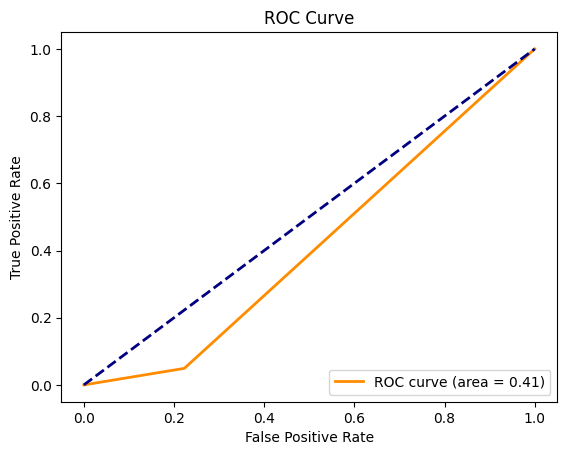

In [17]:
# ROC Curve and AUC for multi-label classification
# Calculating micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()